In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
import os
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
shearSE = fshear['SE']
tcwvfac_all =  ftcw['abs'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

cp4_precip_hist = ftcw['prcp_hist']

ltag = ''

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.7762568058787446
TCW scaling [1.19938758 1.19938758 1.104523   1.17877165 1.17111967 1.15693016
 1.08019338 1.16968217 1.09620372 1.28048504 1.18748565 1.22224398
 1.19137074 1.24554717 1.22338062 1.23320867 1.31619694 1.2043598
 1.32834691 1.20466736]


In [5]:
shearSE

0.14696280270955595

In [6]:
shearfac

0.7762568058787446

In [7]:
mm_to_perc = ((ftcw['prcp_fut']-ftcw['prcp_hist'])/ ftcw['prcp_hist'])   / (ftcw['prcp_fut']-ftcw['prcp_hist'])

In [8]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')

cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc')
cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc')
cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc')
cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc')

cp4_prcp_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm_4km.nc')
cp4_prcp_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm_4km.nc')

In [9]:
cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
cp4_shear_fut = cp4_u925_fut-cp4_u600_fut

In [10]:
def cmip_prep(y):
    cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+str(y)+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
    cmip_shear_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+str(y)+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
    
    cmip6_tcw_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_'+str(y)+'/CMIP6_*.nc')
    cmip6_shear_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_'+str(y)+'/CMIP6_*.nc')
    
    cmip6_tcw = []
    for cmi in cmip6_tcw_files:
        da = xr.open_dataset(cmi)

        da_out = cmip_tcw_map.salem.transform(da)
        cmip6_tcw.append(da_out)
        
    cmip6_tcw_ds = xr.concat(cmip6_tcw, dim='model_name')
    cmip_tcw_map = xr.merge([cmip_tcw_map,cmip6_tcw_ds])
    
    cmip6_shear = []
    for cmi in cmip6_shear_files:
        da = xr.open_dataset(cmi)

        da_out = cmip_shear_map.salem.transform(da)
        da_out = da_out.rename({'ua' : 'unknown'})
        da_out = da_out.rename({'ua_hist' : 'unknown_hist'})
        cmip6_shear.append(da_out)
    cmip6_shear_ds = xr.concat(cmip6_shear, dim='model_name')
    cmip_shear_map = xr.merge([cmip_shear_map,cmip6_shear_ds])
    
    return cmip_tcw_map, cmip_shear_map

In [11]:
cmip_tcw_map, cmip_shear_map = cmip_prep(2080)

In [12]:
ds_merge = xr.merge([cmip_tcw_map, cmip_shear_map])

In [13]:
model_names = ds_merge.model_name

In [14]:
box = [-19,20,3,25]

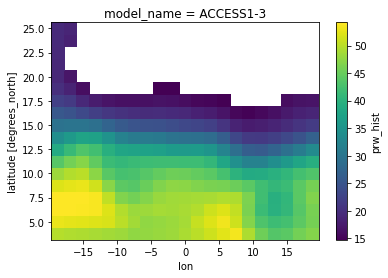

In [15]:
cmip_tcw_map['prw_hist'].sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]), model_name='ACCESS1-3').plot()

In [16]:
cmip_precip_files = ''

In [17]:
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
cp4_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_hist)
cp4f_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_fut)

In [18]:
cp4f_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_fut)
cp4_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_hist)

In [19]:
obs_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

mdomain = [-11,16,4,25]

def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9
    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]

    return dicout

obs_mcs = calc_mcs_stuff(obs_mcs, mdomain)
cp4hist_mcs = calc_mcs_stuff(cp4hist_mcs, mdomain)
cp4fut_mcs = calc_mcs_stuff(cp4fut_mcs, mdomain)

In [20]:
mcs_gridded = cp4_tcw_onCmip['tcwv']
def add_lonlat_todic(dic,grid):
    try:
        del dic['grid_lon']
        del dic['grid_lat']
    except:
        pass
    grid_lon = []
    grid_lat = []
    for lonx, laty in zip(dic.lon, dic.lat):
        point = grid.sel(lat=laty, lon=lonx, method='nearest') #, tolerance=0.9

        grid_lat.append(float(point.lat.values))
        grid_lon.append(float(point.lon.values))
    dic['grid_lon'] = grid_lon
    dic['grid_lat'] = grid_lat

In [21]:
add_lonlat_todic(cp4hist_mcs, mcs_gridded)
add_lonlat_todic(cp4fut_mcs, mcs_gridded)

In [22]:
def assign_to_grid(dic, grid, var):
    mcs_array = np.zeros_like(grid.values)*np.nan
    tcw_array = np.zeros_like(grid.values)*np.nan
    shear_array = np.zeros_like(grid.values)*np.nan
    for yy, lat in enumerate(grid.lat):
        for xx, lon in enumerate(grid.lon):
            
            posi = np.where((dic['grid_lon']==lon) & (dic['grid_lat']==lat))
            precip = np.array(dic[var])[posi]
            tcw = np.array(dic['tcwv'])[posi]
            shear = np.array(dic['shear'])[posi]
            ppos = np.where(precip>0.1)
            valid = np.sum(precip>0.1)
            
            precip = precip[ppos]
            tcw = tcw[ppos]
            shear = shear[ppos]

            try:

                tperc = np.percentile(tcw, 95)
                sperc = np.percentile(shear, 95)
                perc = np.percentile(precip, 95)  #[(tcw > tperc) & (tcw<tttperc)]

######################################

#                 tcw95 = np.percentile(tcw, 95)
#                 tcw99 = np.percentile(tcw, 99.9)
        
#                 shear95 = np.percentile(shear, 95)
#                 shear99 = np.percentile(shear, 99.9)

#                 tperc = np.median(tcw[(tcw>=tcw95) & (tcw<=tcw99)])
#                 sperc = np.median(shear[(shear>=shear95) & (shear<=shear99)])
                
#                 perc = np.percentile(precip[(tcw>=tcw95) & (tcw<=tcw99)], 95)  #[(tcw > tperc) & (tcw<tttperc)]
            
            except:
                perc = np.nan
                tperc = np.nan
                sperc = np.nan
            if valid < 5:
                perc=np.nan
            mcs_array[yy,xx] = perc
            tcw_array[yy,xx] = tperc
            shear_array[yy,xx] = sperc
    outarr = grid.copy(deep=True)
    tarr = grid.copy(deep=True)
    sarr = grid.copy(deep=True)
    outarr.values = mcs_array
    tarr.values = tcw_array
    sarr.values = shear_array
    return outarr, tarr, sarr  

In [23]:
cp4_mcs_grid, cp4_tcw_grid,cp4_shear_grid = assign_to_grid(cp4hist_mcs,mcs_gridded, 'prcp')
cp4f_mcs_grid, cp4f_tcw_grid,cp4f_shear_grid = assign_to_grid(cp4fut_mcs,mcs_gridded, 'prcp')

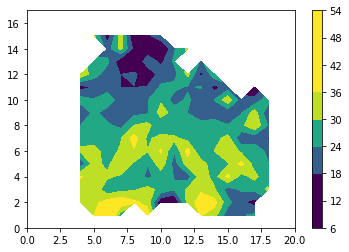

In [24]:
plt.contourf(cp4f_mcs_grid-cp4_mcs_grid, vmin=15, vmax=35)
plt.colorbar()


In [25]:
cpftest = cp4f_mcs_grid.sel(lon=slice(-10, 15), lat=slice(9, 19)).mean().squeeze() 
cphtest = cp4_mcs_grid.sel(lon=slice(-10, 15), lat=slice(9, 19)).mean().squeeze()
(cpftest-cphtest)/cphtest

<xarray.DataArray 'tcwv' ()>
array(0.67831844, dtype=float32)

In [26]:
tcwvfac_all

array([1.19938758, 1.19938758, 1.104523  , 1.17877165, 1.17111967,
       1.15693016, 1.08019338, 1.16968217, 1.09620372, 1.28048504,
       1.18748565, 1.22224398, 1.19137074, 1.24554717, 1.22338062,
       1.23320867, 1.31619694, 1.2043598 , 1.32834691, 1.20466736])

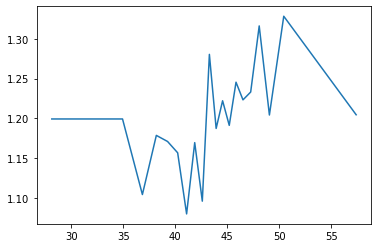

In [27]:
plt.plot(ftcw['tcw_hist'], tcwvfac_all)

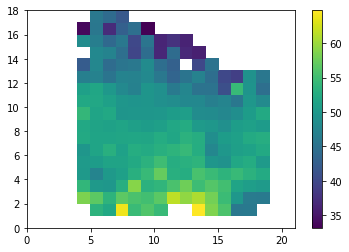

In [28]:
plt.pcolormesh(cp4_tcw_grid.values)
plt.colorbar()

In [29]:
np.mean(tcwvfac_all)

1.1996745900023602

In [30]:
def percentile_contribution(p90, ds_merge):
    contr = p90.copy(deep=True)
    fillarr = np.zeros_like(p90.values)*np.nan

    for latid, lats in enumerate(p90.lat):
        for lonid, lons in enumerate(p90.lon):

            ds = ds_merge.sel(lat=lats, lon=lons)

            if np.isnan(p90.sel(lat=lats, lon=lons).values):
                continue
            
            pos = np.where(p90.sel(lat=lats, lon=lons).values == ds['sum'].values)
           # ipdb.set_trace()
            try:
                #ipdb.set_trace()
                ctr = ds['contribution'].isel(model_name=pos[0]).values
                fillarr[latid, lonid] = ctr
            except:
                print('Error')
                continue
    contr.values = fillarr
    return contr

In [31]:
def get_model_name(path):
    names = []
    files = glob.glob(path+'/*.nc')
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[1]
        names.append(model)
    return names

In [32]:
def prep_cmip_list(region):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip5_read = {}
    cmip_read = {}
    for dd in dics:
        cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP_'+region+'.csv', index_col='model_name')
        
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip6_read = {}
    for dd in dics:
        cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_'+region+'.csv', index_col='model_name')

    for dd in dics:
        cmip_read[dd[1]] = pd.concat([cmip5_read[dd[1]], cmip6_read[dd[1]]])
        cmip_read[dd[1]] = cmip_read[dd[1]].dropna()
    
    return cmip_read

In [33]:
def prep_cmip5_precip(region, tag):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
    dics = [('2070-2100', '2080')] #('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), 
    cmip5_read = {}
    cmip_read = {}
    if tag != 'RAW3h':
        for dd in dics:
            cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP_'+region+'.csv', index_col='model_name')

            cmip5_read[dd[1]] = cmip5_read[dd[1]].dropna()
            #cmip5_read[dd[1]] = (cmip5_read[dd[1]])[(cmip5_read[dd[1]])['pr_mean']>0]
    
    if tag == 'RAW':
        
        base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
        dics = [('2070-2100', '2080')]
        cmip6_read = {}
        for dd in dics:
            cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP6_'+region+'.csv', index_col='model_name')

        for dd in dics:
            cmip_read[dd[1]] = pd.concat([cmip5_read[dd[1]], cmip6_read[dd[1]]])
            cmip_read[dd[1]] = cmip_read[dd[1]].dropna()
            
    if tag == 'RAW3h':
        
        base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
        dics = [('2070-2100', '2080')]

        for dd in dics:
            cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP6_'+region+'.csv', index_col='model_name')

            
    return cmip5_read, cmip_read

In [34]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [35]:
def draw_map(ax, dat, lat, lon, title='', levels=None, cbarlabel='', cmap='', bl=False, ll=True, boxlabel=False):
    import matplotlib.ticker as mticker
    
    ax.set_facecolor('lightgrey')
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, alpha=0.7, extend='both')
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.contour(lon, lat, dat, transform=ccrs.PlateCarree(), colors='white', levels=levels, linewidths=0.1)
    ax.coastlines()
    #Gridlines
    xl = ax.gridlines(draw_labels=True, linestyle='dotted', linewidths=0.001);
    xl.top_labels = False
    xl.xlines = False
    xl.ylines=False
    xl.right_labels = False
    xl.bottom_labels = bl
    xl.left_labels = ll
    xl.ylocator = mticker.FixedLocator([6, 9, 12,15,18])
    xl.xlocator = mticker.FixedLocator([-15, -10,-5,0,5,10,15])
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
   # plt.grid(False)
    plt.title(title, fontsize=10)
    
    ax.set_ylim(3.7,21)
    ax.set_xlim(-17.5,16)

#     ax.set_ylim(9,19)
#     ax.set_xlim(-10,15)
    
    x=2
    y=1.1
    ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
    niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
    timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
    bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
    

    
    rect1 = patches.Rectangle((-10,9),25,10,linewidth=1.5,edgecolor='k',facecolor='none', zorder=98)

    ax.add_patch(rect1)

    
    if boxlabel:
        #plt.text(-3.42,12.65, '1', fontsize=8, color='w')
        plt.text(0.195,13.9, '3', fontsize=8, color='w')
        plt.text(-4.85,17, '2', fontsize=8, color='w')
        plt.text(-9.8,13, '1', fontsize=8, color='w')
        
        plt.text(-8,13, 'Mali', fontsize=8, color='k')
        plt.text(-3.46,11.8, 'Burkina Faso', fontsize=8, color='k')
        plt.text(6,15.5, 'Niger', fontsize=8, color='k')
        plt.text(7,11, 'Nigeria', fontsize=8, color='k')
        

        #ax.plot(-1.52, 12.38, marker='o',  color='w', linestyle='', markersize=1)  #transform=ax.transAxes,
        ax.plot(2.13, 13.5, marker='o',  color='w', linestyle='', markersize=1)
        ax.plot(-3, 16.8, marker='o',  color='w', linestyle='', markersize=1)
        ax.plot(-8, 12.6, marker='o',  color='w', linestyle='', markersize=1)

    
        #rect2 = patches.Rectangle((ouaga[0],ouaga[2]),ouaga[1]-ouaga[0],ouaga[3]-ouaga[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        rect3 = patches.Rectangle((niamey[0],niamey[2]),niamey[1]-niamey[0],niamey[3]-niamey[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        rect4 = patches.Rectangle((timbuktu[0],timbuktu[2]),timbuktu[1]-timbuktu[0],timbuktu[3]-timbuktu[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        rect2 = patches.Rectangle((bamako[0],bamako[2]),bamako[1]-bamako[0],bamako[3]-bamako[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
        ax.add_patch(rect2)
        ax.add_patch(rect3)
        ax.add_patch(rect4)



In [36]:
def calc_mcs(dd):

    obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs95 = calc_mcs_stuff(obs_mcs_d, dd).quantile(0.95)
    cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile(0.95)
    cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile(0.95)
    
    return cp4hist_mcs95, cp4fut_mcs95, obs_mcs95

In [37]:
def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    
    return dicout

In [38]:
import seaborn as sns

cmip_colors = sns.color_palette("inferno_r", 8) #.cubehelix_palette(start=.5, rot=-.5)

In [53]:
calc_mcs_stuff(obs_mcs, timbuktu)

,prcp,q925,q650,t925,pall,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
34,13.821370,13.254479,5.513952,26.653375,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02372425805245545,...",9.513326,7,23575,-71.530314,55.929729,-1.787058,32.528675,41.655270,0.166691,2.863922,16.946067,-3.183664
114,17.042454,13.357548,5.579134,27.128259,"[0.0, 0.0, 0.05276200632415121, 0.0, 0.0, 0.12...",8.419459,7,15875,-58.769245,54.809433,-0.709006,35.683553,41.299187,0.168954,2.858490,16.861677,-3.697387
286,38.140397,14.316226,5.893869,28.064050,"[0.023533808016149998, 3.1412465980676236, 0.0...",17.208992,8,14300,-85.851315,55.770206,9.420776,47.800265,43.090096,0.164689,5.002594,15.693176,-2.979740
344,5.840696,12.007910,6.545656,29.465662,"[0.15009260090754947, 0.10966837631079845, 0.0...",13.843849,9,12400,-70.630220,43.165680,4.204806,57.810295,41.549992,0.147704,3.551575,17.555372,-3.967815
452,17.642954,9.850143,5.332599,30.986047,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15.004730,9,6675,-70.000000,32.561996,-1.666440,68.285335,33.116028,0.178804,5.356750,17.067084,-3.017665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3826,11.872325,9.774257,5.085836,31.414606,"[0.0, 1.5908366021146663, 3.5735242745247104, ...",13.660253,9,20225,-81.298246,31.305937,-0.571463,72.569469,28.498955,0.198429,6.546326,16.798490,-3.827104
4082,0.391235,8.610166,4.171964,31.829126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13.890588,9,9375,-58.000000,27.000151,-4.300867,75.304942,29.771284,0.178793,6.124084,16.980359,-1.507287
4099,12.827774,13.139296,5.679820,31.050928,"[2.6426494589850074, 4.2326689441735965, 4.977...",17.397156,9,5925,-84.734784,43.079433,5.467507,65.790134,41.755688,0.207440,6.144440,15.876587,-1.908984
4186,1.792705,14.315748,5.599032,29.175531,"[0.1291943752338651, 0.43009713559604684, 0.34...",22.001839,8,108075,-76.000000,52.148933,5.946294,50.668117,44.525986,0.189312,4.855469,15.710613,-1.666119


In [40]:
check = prep_cmip_list('niamey')['2080']

In [41]:
pos = np.where(np.isnan(prep_cmip_list('niamey')['2080']['tcw_mean']))

In [42]:
check.index[int(pos[0])]

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
(prep_cmip_list('niamey')['2080'])[pos]

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


NameError: name 'all_cmip5_raw' is not defined

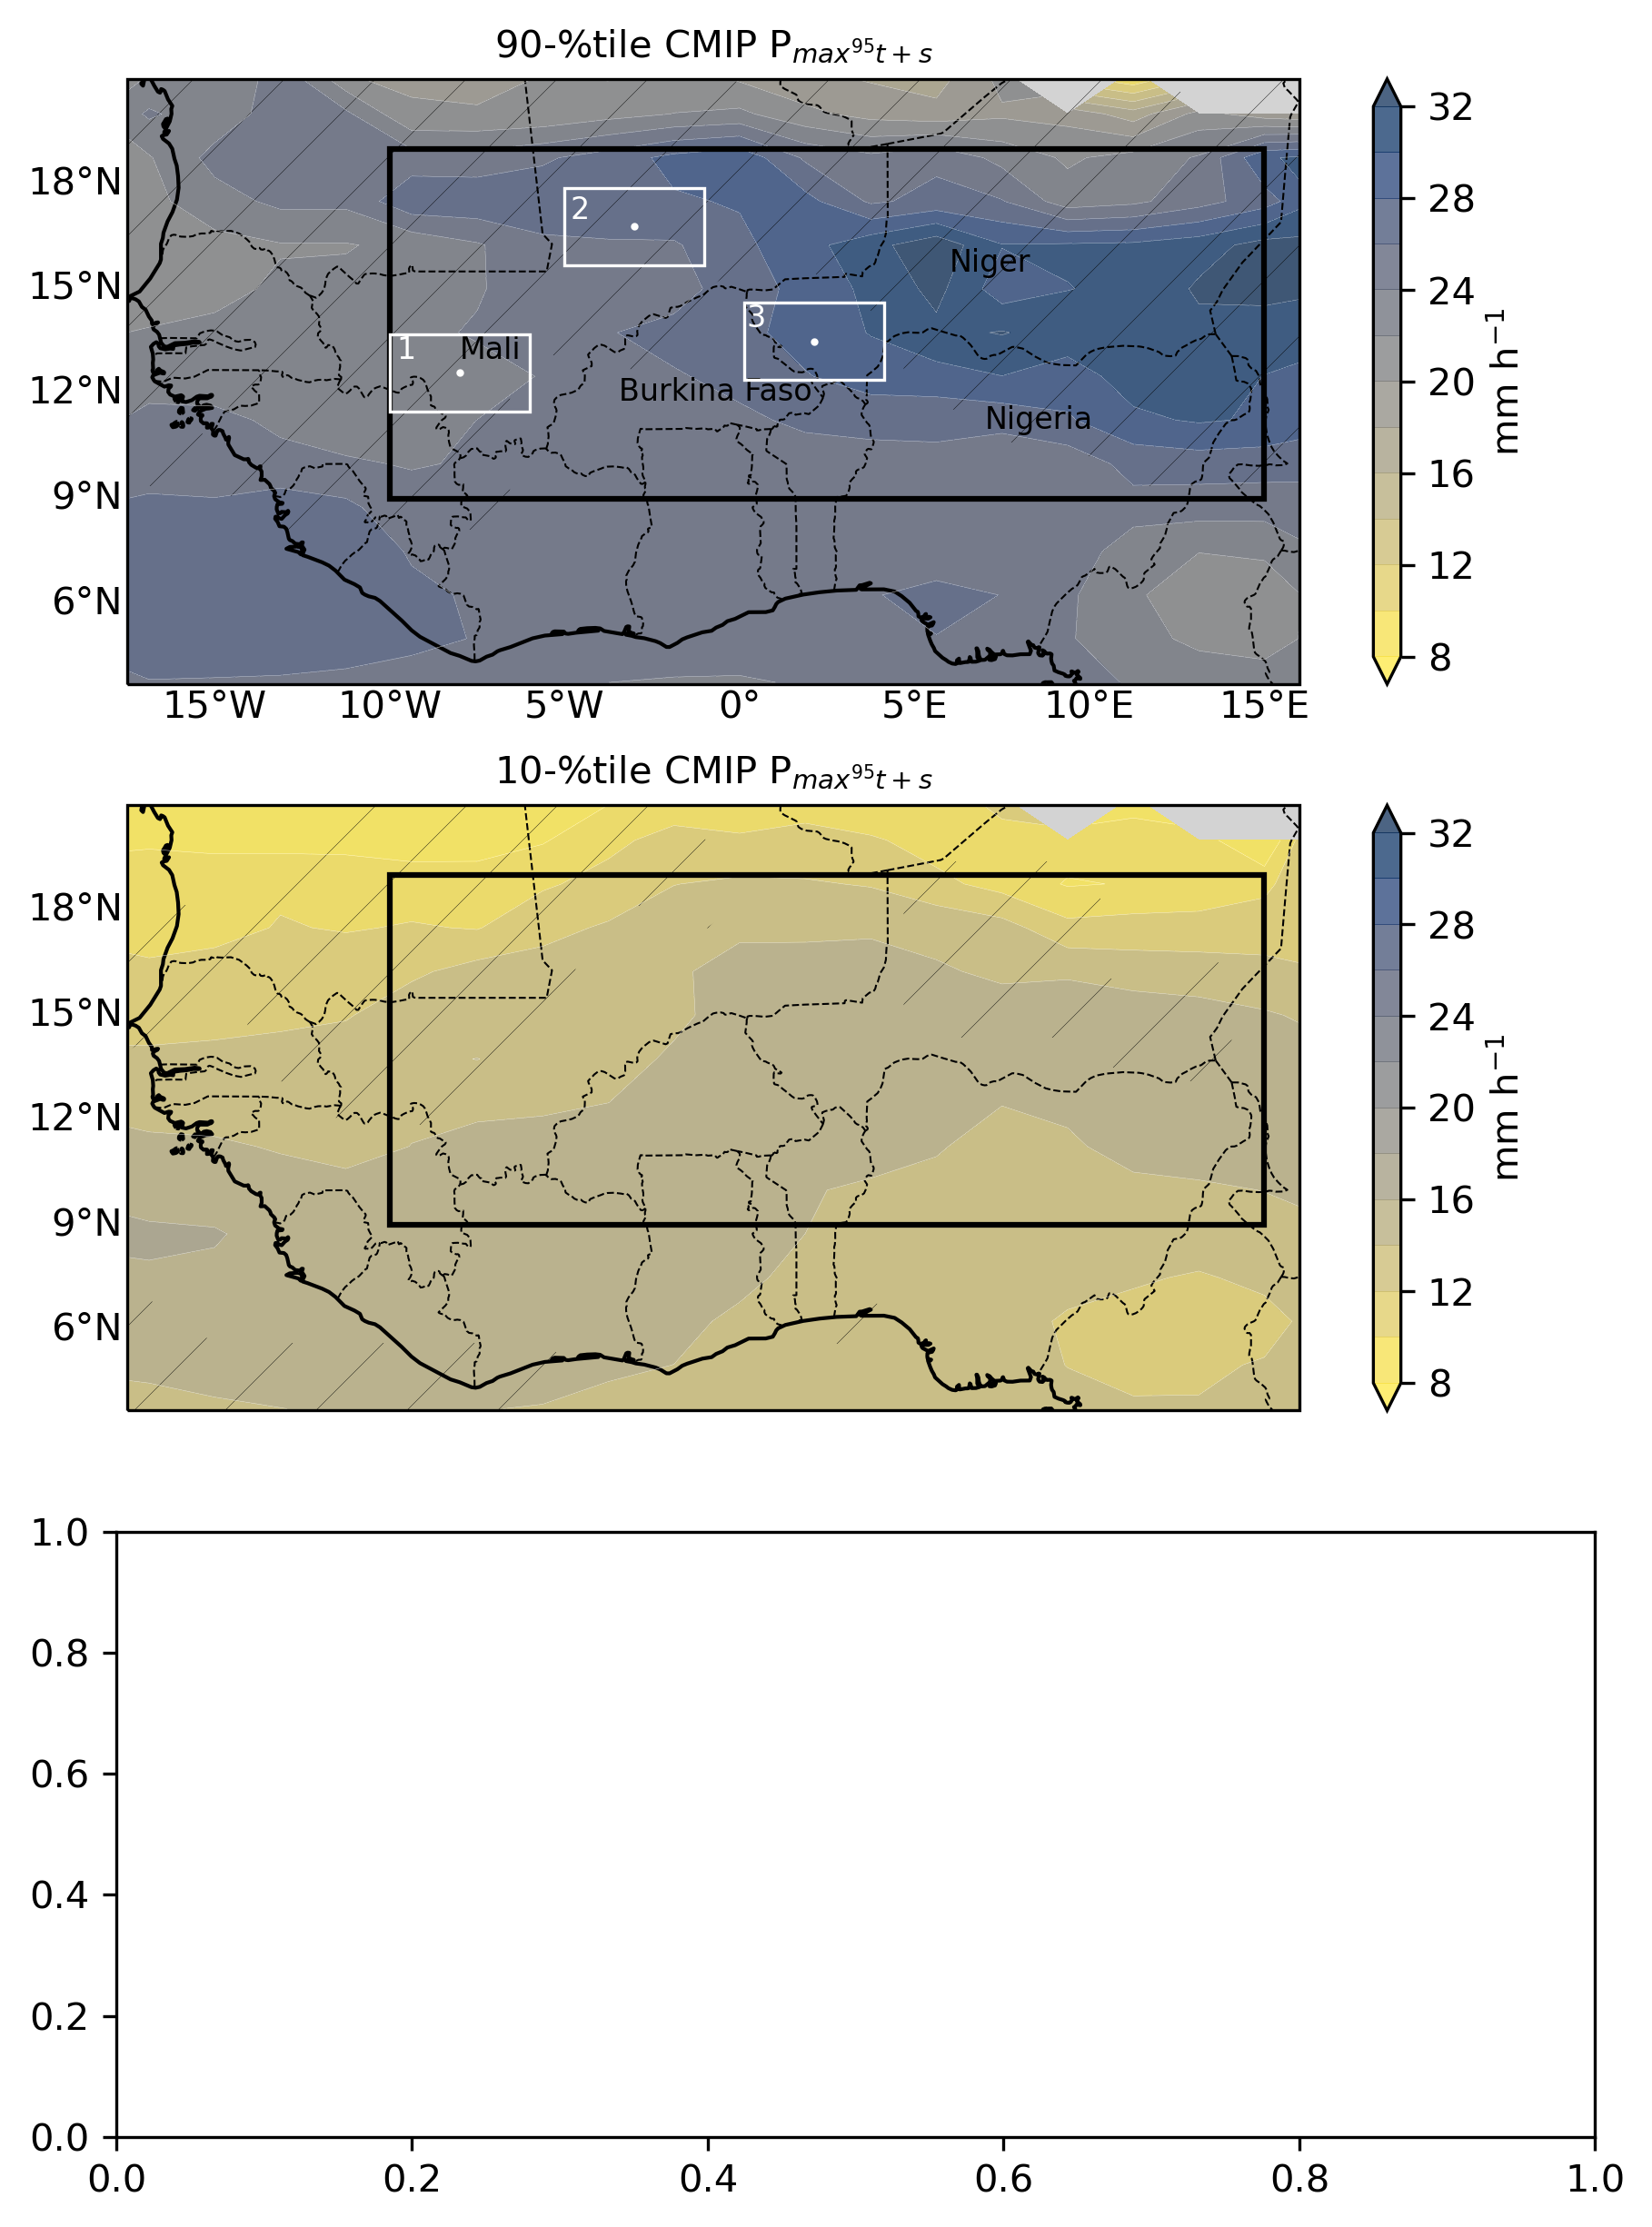

In [45]:

from matplotlib.lines import Line2D
sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]



#box = [-18,16,4,22]

regions = {'bamako' : (bamako, 'Bamako'), 'sahel':(sahel, 'Sahel'),  'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}  #'ouaga':(ouaga, 'Ouagadougou'),

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
mpl.rcParams['hatch.color'] = 'k'  # previous pdf hatch linewidth
#lats = cp4_tcw_onCmip.lat.values

#############################################################
#f = plt.figure(figsize=(12.5,7), dpi=300)
f = plt.figure(figsize=(7,10), dpi=300)

slevels=np.arange(-15,16,3)
box = [-19,17,3,25]
tag='10'
yy ='2080'

tcw_map, sh_map = cmip_prep(yy)
ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

##relative CMIP change
ds_shear = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw'].where(ds_merge['prw_hist']>21.5))#/ds_merge['prw_hist'])

ar_list = []

for mids in ds_merge['prw'].model_name:
   
    new_ar_list =  cmip_rel.sel(model_name=mids)  * np.mean(tcwvfac_all)  #* cp4_tcw_onCmip['tcwv']
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)
    
ds_scaled = xr.concat(ar_list, dim='model_name')

ds_merge['sum'] =  ds_shear +ds_scaled  #
ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

#ipdb.set_trace()

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(3,1,2, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP P$_{max^{95}t+s}$', levels=np.arange(8,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 
cont = gauss(contr10.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=8, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])

tag='90'
ax = f.add_subplot(3,1,1, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP P$_{max^{95}t+s}$', levels=np.arange(8,34,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True, boxlabel=True) 
cont = gauss(contr90.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=8, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])




import seaborn as sns

colors = sns.cubehelix_palette(start=.5, rot=-.75)
ax = f.add_subplot(3,1,3)
#ax1 = ax.twiny()
#bpos = np.array([0.3,1, 1.8])
labels = ['Sahel', 'Bamako' , 'Timbuktu', 'Niamey']
err_ind = [0,3,6,9]
bpos = np.linspace(0.49,2.16,len(labels))
print('Model number', len(all_cmip5_raw[0]))
ax.boxplot(all_cmip_ll, positions=bpos+0.06, labels=labels, whis=[10,90], patch_artist=True, widths=0.05, boxprops=dict(facecolor=colors[2], lw=0.5), sym='.', meanprops = dict(markeredgewidth=0.5, marker='o', markersize=3, markeredgecolor='k',
                      markerfacecolor='seagreen'), medianprops=dict(color='k'), flierprops=dict(markersize=1), showmeans=True)
ax.boxplot(all_cmip5_raw, positions=bpos+0.166, labels=['']*len(labels),  whis=[10,90], patch_artist=True, widths=0.05, boxprops=dict(facecolor='lightgrey', lw=0.5), manage_ticks=False, sym='.', medianprops=dict(color='k'), 
           flierprops=dict(markersize=1), showmeans=True,meanprops = dict(markeredgewidth=0.5, marker='o', markersize=3, markeredgecolor='k', markerfacecolor='lightgrey'))
# for bposid, bppos in enumerate(bpos):
#     ax.scatter([bppos+0.22]*len(all_cmip5_3hequi[bposid]), all_cmip5_3hequi[bposid], color=cmip_colors[1:5], marker='_', s=6, zorder=99)

ax.boxplot(all_cmip5_bc, positions=bpos+0.22, labels=['']*len(labels),  whis=[10,90], patch_artist=True, widths=0.05, boxprops=dict(facecolor='lightblue', lw=0.5), manage_ticks=False, sym='.', medianprops=dict(color='k'), 
           flierprops=dict(markersize=1), showmeans=True,meanprops = dict(markeredgewidth=0.5, marker='o', markersize=3, markeredgecolor='k', markerfacecolor='lightblue'))

for alll in all_cmip_ll:
    print('Ensemble mean', np.mean(alll), np.percentile(alll,10), np.percentile(alll,90))
    
for alll in all_cmip5_raw:
    print('Ensemble mean raw', np.mean(alll), np.percentile(alll,10), np.percentile(alll,90))
    
for alll in all_cmip5_bc:
    print('Ensemble mean BC', np.mean(alll), np.percentile(alll,10), np.percentile(alll,90))
# ax.boxplot(all_cmip5_3hequi, positions=bpos+0.27, labels=['']*len(labels),  whis=[25,75], patch_artist=True, widths=0.025,  boxprops=dict(facecolor='lightgrey', ec='white', lw=1, alpha=0.7), manage_ticks=False, sym='.', medianprops=dict(color='grey'), whiskerprops=dict(color='white'),showfliers=False)
# ax.boxplot(all_cmip5_3h, positions=bpos+0.3, labels=['']*len(labels),  whis=[25,75], patch_artist=True, widths=0.025,  boxprops=dict(facecolor='lightgrey', ec='white', lw=1, alpha=0.7), manage_ticks=False, sym='.', medianprops=dict(color='grey'), whiskerprops=dict(color='white'),showfliers=False)



# for bposid, bppos in enumerate(bpos):
#     ax.text(bppos+0.26, np.percentile(all_cmip5_3hequi[bposid],70), 'd', fontsize=4)
#     ax.text(bppos+0.29, np.percentile(all_cmip5_3h[bposid],70), 'h', fontsize=4)
    
#     d3hp = all_cmip5_3hequi[bposid].drop('IPSL-CM6A-LR')
#     hp3 = all_cmip5_3h[bposid].drop('IPSL-CM6A-LR')
    
#     #ipdb.set_trace()
#     plt.vlines(x=bppos+0.27, ymin=np.min(d3hp), ymax=np.max(d3hp), color='lightgrey', zorder=1, linewidth=5, alpha=0.5)
#     plt.vlines(x=bppos+0.3, ymin=np.min(hp3), ymax=np.max(hp3), color='lightgrey', zorder=1, linewidth=5, alpha=0.5)
#     for modid, smodel in enumerate(all_cmip5_3h[0].index.values):
#         if 'IPSL' in smodel:
#             continue
        #ipbd.set_trace()
        #ax.plot([bppos+0.22,bppos+0.27], [(all_cmip5_3hequi[bposid])[smodel], (all_cmip5_3h[bposid])[smodel]], color=cmip_colors[modid], zorder=99, markersize=5, linestyle='solid', marker='_', linewidth=1)
        
        # ipdb.set_trace()

#         ax.scatter([bppos+0.22], (all_cmip5_3hequi[bposid])[smodel], color=cmip_colors[modid], marker='_', s=8, zorder=99)
#         ax.scatter([bppos+0.27], (all_cmip5_3h[bposid])[smodel], color=cmip_colors[modid], marker='_', s=8, zorder=99)
        


cpshift = 0.06
#plt.scatter(bpos, all_cp4_scaled, marker='x', color=colors[2])
#plt.scatter(bpos+cpshift, all_cp4_raw, marker='x', color='blue')
#plt.scatter(bpos, tcw_cp4_scaled, marker='x', color='k')

posmin = np.array(all_cp4_raw) > np.array(all_cp4_p95_grid)
iscp4 = np.array(all_cp4_raw).copy()
iscp4[posmin] = np.array(all_cp4_p95_grid)[posmin]
# plt.scatter(bpos, all_cp4_raw, marker='x', color='k')
# plt.scatter(bpos, all_cp4_p95_grid, marker='x', color='b')
plt.scatter(bpos, iscp4, marker='x', color='k')  #all_cp4_p95_grid

print('CP4 raw', iscp4)


for eids, ebpos in enumerate(bpos):
    locat=err_ind[eids]
    mid = cp4_error_total[locat+2]#np.mean(cp4_error_total[locat:locat+2])
    mins = cp4_error_total[locat]
    maxs = cp4_error_total[locat+1]
    
    midt = cp4_tcw_total[locat+2]
    minst = cp4_tcw_total[locat]
    maxst = cp4_tcw_total[locat+1]
   # ipdb.set_trace()
   # ax.axvline(ebpos+0.11,mins,maxs, color='seagreen', linewidth=7, alpha=0.5)
    #plt.vlines(x=ebpos, ymin=minst, ymax=maxst, color='k', zorder=1, linewidth=4, alpha=0.3)
    plt.vlines(x=ebpos, ymin=mins, ymax=maxs, color='seagreen', zorder=1, linewidth=4, alpha=0.3)
    print('Difference TCW/shear, min/max:', (mins-minst).values, (maxs-maxst).values)
    print('Max-min CP4', maxs.values-mins.values)
    print('Min, Max, Mean CP4 scaled', mins.values, maxs.values, mid.values)
    plt.scatter(ebpos, mid, marker='x', color=colors[2])

xer = -35
for pids, ppos in enumerate(bpos):
    plt.text(ppos-0.02, xer, str( np.round(cp4_hist_rain[pids],2)), fontsize=8)
plt.text(-0.25,xer, 'CP4$_H$ (mm h$^{-1}$):', fontsize=8)
plt.xlim(-0.3,2.5)
plt.ylim(-40,135)
plt.ylabel('$\Delta$ Precipitation (%)')
plt.axhline(0, color='k')


legend_elements = [ Line2D([0], [0], color='seagreen', lw=1, label='CP4 P$_{max^{95}t+s}$', linestyle='', marker='x', markersize=4),
            Line2D([0], [0], color='k', label='CP4$_{modelled}$ P$_{max^{95}}$', linestyle='', marker='x', markersize=4),
                Line2D([0], [0], color='seagreen', lw=6, label='CMIP P$_{max^{95}t+s}$', linestyle='solid', mec='k'),
                   Line2D([0], [0], color='lightgrey', lw=6, label='CMIP$_{modelled}$ daily-P95', linestyle='solid'),
               Line2D([0], [0], color='lightblue', lw=6, label='CMIP5-BC daily-P95', linestyle='solid')]

#Line2D([0], [0], marker='x', color='k', label='CP4 P$_{max^{95}t}$',  markerfacecolor='k', markersize=4, linestyle=''),
ax.legend(handles=legend_elements, loc='upper left', fontsize=8, frameon=False)

plt.tight_layout()

print('CP4 difference', np.array(all_cp4_scaled)-np.array(all_cp4_raw))

#f.subplots_adjust(left=0.001)

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.06
x2 = 0.5

plt.annotate(text[0], xy=(x1, 0.958), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x1, 0.638), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.33), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[3], xy=(x2, 0.46), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[4], xy=(x1, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[5], xy=(x2, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)



f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2080_absolute_CP4_0.1mm_locScaling_posPrcp'+str(yy)+'_boxplot_addedUncert_daily_wMean.jpg')

In [ ]:
sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y ]

regions = {'bamako': (bamako, 'Bamako'), 'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu'), 'dakar': (dakar, 'Dakar')}

all_cmip = []
all_cmip_list = []
all_cp4_scaled = []
tcw_cp4_scaled = []
all_cp4_raw = []
all_cp4_p95_grid = []
all_cmip5_raw = []
all_cmip5_bc = []
all_cmip5_3h = []
all_cmip5_3hequi = []
cp4_hist_rain = []

cp4_error_total = []
cp4_tcw_total = []

for idss, rname in enumerate(['sahel', 'bamako',  'timbuktu', 'niamey']):   #'ouaga',
#cp4f_mcs_grid-

    region = rname

    box = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['abs']) 

    dirs = regions

    cp4_tcw_diff = cp4_tcw_fut-cp4_tcw_hist
    cp4_tcw_diff = cp4_tcw_diff['tcwv'].sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3])).mean().squeeze()

    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist


    cp4_shear_diff = cp4_shear_fut-cp4_shear_hist
    cp4_shear_diff = cp4_shear_diff.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3])).mean().squeeze()
    
    cp4_mcs_diff_grid = (cp4f_mcs_grid - cp4_mcs_grid)/cp4_mcs_grid*100
    cp4_mcs_diff_grid = cp4_mcs_diff_grid.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).mean().squeeze()
    cp4_mcs_hist_grid = cp4_mcs_grid.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).mean().squeeze()

    yy = '2080'
    tcw_map, sh_map = cmip_prep(yy)
    ds_merge = xr.merge([tcw_map, sh_map])
    ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean(['lat','lon']).squeeze()

    #ax.axhline(100, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'tcw' : [], 'shear' : [], 'total':[]}
    fdiclist = {'tcw' : [], 'shear' : [], 'total':[]}
    cpdic = {'tcw' : [], 'shear' : [], 'total':[]}

    cmip_list = prep_cmip_list(region)
    cmip_list = cmip_list[yy]
    
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(box) 

    #mm_to_perc = (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'] /  (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp']) *100
    mm_to_perc = np.mean(((ftcw['prcp_fut']-ftcw['prcp_hist'])/ ftcw['prcp_hist'])   / (ftcw['prcp_fut']-ftcw['prcp_hist']))*100
    print(mm_to_perc)
        
    tcwvfac = np.mean(tcwvfac_all)
    
    #####get CMIP raw hourly
    p_hourly_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')
    nouse, cmip_rainfall_3h = prep_cmip5_precip(region, 'RAW3h')
    cmip_rainfall_3h = cmip_rainfall_3h['2080']
    cmipr_out_3h = cmip_rainfall_3h['pr_mean'] / cmip_rainfall_3h['pr_hist'] * 100
    all_cmip5_3h.append(cmipr_out_3h)

    
    
    ####get CMIP raw daily
    cmip_rainfall, nouse = prep_cmip5_precip(region, 'BC')
    nouse, cmip_rainfall_R = prep_cmip5_precip(region, 'RAW')
    cmip_rainfall = cmip_rainfall['2080']
    cmip_rainfall_R = cmip_rainfall_R['2080']
    cmipr_out = cmip_rainfall['pr_mean'] / cmip_rainfall['pr_hist'] * 100
    cmipr_out_R = cmip_rainfall_R['pr_mean'] / cmip_rainfall_R['pr_hist'] * 100
    all_cmip5_bc.append(cmipr_out)
    all_cmip5_raw.append(cmipr_out_R)

    all_cmip5_3hequi.append(cmipr_out_R[p_hourly_names])
    
    #ipdb.set_trace()

    ###get CP4 raw hourly
    all_cp4_raw.append(((cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'])*100) 
    all_cp4_p95_grid.append(cp4_mcs_diff_grid)
    cp4_hist_rain.append(cp4hist_mcs95['prcp'])
    
    cptcw = cp4_tcw_diff* tcwvfac
    cpshear = cp4_shear_diff['u_pl'] * shearfac
    cpdic['tcw'] = cptcw 
    cpdic['shear'] = cpshear
    cpdic['total'] = (cptcw+cpshear) * mm_to_perc #/cp4hist_mcs95['prcp']*100 #* mm_to_perc
    
    all_cp4_scaled.append((cpdic['total']))
    tcw_cp4_scaled.append(cpdic['tcw'] * mm_to_perc)  # 
    
    for fag, tcwvfac in zip(['min','max', 'mean'],[np.min(tcwvfac_all), np.max(tcwvfac_all), np.mean(tcwvfac_all)]):  #   , np.mean(tcwvfac_all)

        if fag == 'mean':
            sfac = shearfac
        if fag == 'min':
            sfac = shearfac-shearSE
        if fag == 'max':
            sfac = shearfac+shearSE

        ds_shear = ds_merge['unknown']*sfac
        ds_tcw = (ds_merge['prw'].where(ds_merge['prw_hist']>21.5)) * tcwvfac #/ds_merge['prw_hist'])
        
        lds_shear = cmip_list['shear_mean'] * sfac
        lds_tcw = cmip_list['tcw_mean'] * tcwvfac
        
        #ipdb.set_trace()

        fdic['tcw']=ds_tcw
        fdic['shear'] = ds_shear
        fdic['total']= (ds_tcw+ds_shear) / cp4_mcs_hist_grid.values*100 #* mm_to_perc#/cp4hist_mcs95['prcp']*100#
        fdic['total'] = fdic['total'].where(np.isfinite(fdic['total']), drop=True)

        fdiclist['tcw']=lds_tcw, 
        fdiclist['shear'] = lds_shear
        fdiclist['total']= (lds_tcw+lds_shear)  / cp4_mcs_hist_grid.values*100 #* mm_to_perc # /cp4hist_mcs95['prcp']*100#* mm_to_perc
        if fag in ['min','max']:
            all_cmip.append(np.array(fdic['total']))
            all_cmip_list.append(np.array(fdiclist['total']))
        
        #ipdb.set_trace()
        
        cptcw = cp4_tcw_diff* tcwvfac
        cpshear = cp4_shear_diff['u_pl'] * sfac
        cpdic['tcw'] = cptcw 
        cpdic['shear'] = cpshear
        cpdic['total'] = (cptcw+cpshear) * mm_to_perc #/cp4hist_mcs95['prcp']*100 #* mm_to_perc
        cp4_error_total.append(cpdic['total'])
        cp4_tcw_total.append(cpdic['tcw']* mm_to_perc)

In [ ]:
all_cmip_ll = []
for poss in [0,2,4,6]:
    merg = np.concatenate([all_cmip_list[poss], all_cmip_list[poss+1]])
    all_cmip_ll.append(merg)

In [ ]:
# all_cmip_ll = []
# for poss in [0,3,6,9]:
#     merg = np.concatenate([all_cmip_list[poss], all_cmip_list[poss+1], all_cmip_list[poss+2]])
#     all_cmip_ll.append(merg)

In [ ]:
all_cmip_ll

In [ ]:
f = plt.figure(figsize=(18,7), dpi=200)
cnt=1
for pn in p_hourly_names:
    ax = f.add_subplot(2,2,cnt)
    
    ##1 
    testdiff = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_'+pn+'_ssp585_3hr_*.nc')[0])
    testhist = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/CMIP6_'+pn+'_historical_day_*.nc')[0])
    testfut = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/CMIP6_'+pn+'_ssp585_day_*.nc')[0])
    
    plt.scatter(testdiff['pr_hist'], testhist['pr'], color='blue')
    plt.scatter(testdiff['pr_hist']+testdiff['pr'], testfut['pr'], color='red', alpha=0.1)
    
    plt.plot(np.arange(0,0.003,0.001), np.arange(0,0.003,0.001), color='k')
    
    cnt +=1

In [ ]:
p_hourly_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')

In [ ]:
p_daily = []
p_hourly = []
lats = []
region='sahel'
box = (regions[region])[0]
box = [-10, 15, 8, 18]
for pn in p_hourly_names:
    
    ph = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/*'+pn+'_*_'+'3hr*')[0])
    pd = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/*'+pn+'_*_'+'day*')[0])

    ph = ph.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3]))
    pd = pd.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3]))
    ph = ph.where((ph['pr_hist']+ph['pr'])<0.003)
    pd = pd.where((pd['pr_hist']+ph['pr'])<0.003)
    if (pn not in ph.model_name) | (pn not in pd.model_name):
        ipdb.set_trace()
        
    p_hourly.append((ph['pr']/ph['pr_hist']*100))
    p_daily.append((pd['pr']/pd['pr_hist']*100))

In [ ]:
cp4_gridMCS_precip_domain = (cp4f_mcs_grid - cp4_mcs_grid)/cp4_mcs_grid*100


In [ ]:
f = plt.figure(figsize=(18,7), dpi=200)
cnt=1
for phh, pdd in zip(p_hourly, p_daily):
    ax = f.add_subplot(2,2,cnt, projection=ccrs.PlateCarree())
    #lati,loni = np.meshgrid(phh.lat, phh.lon)
    plt.contourf(pdd.lon, pdd.lat, pdd.squeeze(), transform=ccrs.PlateCarree())
    ax.coastlines()
    
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.colorbar()
    
    plt.title(str(phh.model_name.values))
    cnt+=1

In [ ]:
f = plt.figure(figsize=(18,7), dpi=200)
cnt=1
for phh, pdd in zip(p_hourly, p_daily):
    ax = f.add_subplot(2,2,cnt, projection=ccrs.PlateCarree())
    #lati,loni = np.meshgrid(phh.lat, phh.lon)
    plt.contourf(pdd.lon, pdd.lat, pdd.squeeze(), transform=ccrs.PlateCarree())
    ax.coastlines()
    
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.colorbar()
    
    plt.title(str(phh.model_name.values))
    cnt+=1

In [ ]:
f = plt.figure(figsize=(9,8), dpi=200)
cnt=1
colors = ['r', 'b', 'orange', 'purple']
resos = ['100km', '250km', '250km', '250km']

for phh, pdd in zip(p_hourly, p_daily):
    ax = f.add_subplot(2,2,cnt)
    lati,loni = np.meshgrid(phh.lat, phh.lon)
    mp = ax.scatter(phh, pdd, color=colors[cnt-1])
    #plt.colorbar(mp)
    #ipdb.set_trace()

    ax.plot(np.arange(0,250), np.arange(0,250), color='k')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    plt.title('CMIP6 Model: '+str(phh.model_name.values[0])+' | '+resos[cnt-1])
    plt.xlabel('$\Delta$p95 3-hourly rainfall (%)')
    plt.ylabel('$\Delta$p95 daily rainfall (%)')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    cnt+=1
    plt.tight_layout()
#     plt.xlim(-10,200)
#     plt.ylim(-10,400)
# f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP6_hourly_daily_scaling.jpg')

In [ ]:
p_hourly[1].model_name

In [ ]:
testdat = cp4_tcw_hist['tcwv'].where(cp4_tcw_hist['tcwv']>25)

In [ ]:
testdat2 = cp4_tcw_fut['tcwv']

In [ ]:
testdat2

In [ ]:
np.sum(np.isnan(testdat.where(np.isfinite(testdat), drop=True)))

In [ ]:
def covariance(x,y,dims=None):

    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)


def correlation(x,y,dims=None):

    return covariance(x,y,dims) / (x.std(dims) * y.std(dims))

In [ ]:
def covariance_gufunc(x, y, dims=None):
    return ((x - x.mean(dims))
            * (y - y.mean(dims))).mean(dims)

def pearson_correlation_gufunc(x, y, dims=None):
    return covariance_gufunc(x, y, dims) / (x.std(dims) * y.std(dims))

In [ ]:
correlation(testdat, testdat2, dims=['latitude', 'longitude'])

In [ ]:
xr.corr(testdat,testdat2)

In [ ]:
pearson_correlation_gufunc(testdat.where(testdat>0, drop=True),testdat2.where(testdat>0, drop=True), dims=['latitude', 'longitude'])

In [ ]:
istrue = np.isfinite(testdat.values.flat)
stats.pearsonr(testdat.values.flat[istrue],testdat2.values.flat[istrue])